# Evaluation suite

***

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import sqlite3 as sql
import math
from matplotlib import pyplot as plt, dates, colors, patches
from datetime import datetime, timedelta
from dateutil.parser import parse
from tqdm import tqdm
from scipy import interpolate
#import process_NEMO_drifters as tools

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 14

***

## Evaluation sandbox

In [3]:
def load_database(
    runID, datatype='drifters', datestr='20160401_20160930',
    path='/project/def-allen/bmoorema/results',

):
    """
    """
    
    fn = f'{path}/{datatype}/SSC{datatype}_{runID}_{datestr}.sqlite'
    con = sql.connect(fn)
    cursor = con.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    
    return con, cursor


def calc_velocities(df, data):
    """
    """
    
    # Calculate drifter velocities based on geolocation
    times = df['time'].values.astype('datetime64[s]').astype(datetime)
    lons, lats = [df[var].values for var in ('longitude', 'latitude')]
    dt = np.array([t.total_seconds() for t in np.diff(times)])
    uv = []
    for coord, theta in zip([lons, lats], [np.deg2rad(lats[:-1]), 0]):
        uv.append(np.diff(coord) / dt * 111000 * np.cos(theta))
    
    # Append results to data dict
    for var, val in zip(['lon', 'lat'], [lons, lats]):
        data['coords'][var].append(val[:-1])
    for var, val in zip(['u', 'v'], rotate_vel(*uv)):
        data['obs'][var].append(val)
        data['nemo'][var].append(df[var].values[:-1])
    
    return data


def rotate_vel(u_in, v_in, theta=29):
    """Rotate velocities from map coordinates to grid coordinates
    """
    
    theta_rad = math.radians(theta)
    u_out = u_in * np.cos(theta_rad) + v_in * np.sin(theta_rad)
    v_out = -u_in * np.sin(theta_rad) + v_in * np.cos(theta_rad)
    
    return u_out, v_out


def calc_stats(x, y):
    """
    """
    
    stats = {}
    MSE = np.mean((y - x)**2)
    stats['RMSE'] = np.sqrt(MSE)
    stats['MAE'] = np.mean(abs(y)) - np.mean(abs(x))
    stats['bias'] = np.mean(y) - np.mean(x)
    stats['WSS'] = 1 - MSE / np.mean((abs(y - np.mean(x)) + abs(x - np.mean(x)))**2)
    
    return stats


def plot_panel(ax, x, y, lims, units, cmax=500, bins=80):
    """
    """
    
    stats = calc_stats(x, y)
    statstext = f"RMSE = {stats['RMSE']:.3f} {units}\nMAE = {stats['MAE']:.3f} {units}\nWSS = {stats['WSS']:.3f}"
    props = dict(boxstyle='round', facecolor='w', alpha=0.9)
    _, _, _, c = ax.hist2d(x, y, bins=bins, range=(lims, lims), norm=colors.LogNorm(vmin=1, vmax=cmax))
    ax.plot(lims, lims, 'r--')
    ax.text(0.5, 0.04, statstext, bbox=props, transform=ax.transAxes)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    return c


def plot_tracers(data, lon_bounds=None, lat_bounds=None, depth_bounds=[0, 5]):
    """
    """
    
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))

    for col, runID in zip(axs.T, ['nowaves', 'frachs08', 'base', 'frachs13', 'charnock']):
        
        # Set title
        col[0].set_title(runID, fontsize=14)

        # Plot
        for ax, var, lims in zip(col, ['temperature', 'salinity'], [(8, 22), (5, 32)]):
            if var == 'temperature':
                var_nemo, units = 'votemper', '$^{\circ}$C'
            elif var == 'salinity':
                var_nemo, units = 'vosaline', 'g/kg'
                
            # Define x and y
            x, y = data[runID][var], data[runID][var_nemo]
            index = np.logical_and(np.isfinite(x), np.isfinite(y))
            for coord, bound in zip(['longitude', 'latitude', 'depth'], [lon_bounds, lat_bounds, depth_bounds]):
                if bound is not None:
                    array = data[runID][coord]
                    index = np.logical_and(index, [bound[0] < element < bound[1] for element in array])
            x, y = x[index], y[index]
            
            # Plot and format
            c = plot_panel(ax, x, y, lims, units=units, cmax=50)
            ax.set_xlabel(f'PSF {var} [{units}]')
            if runID == 'nowaves':
                ax.set_ylabel(f'SSC {var} [{units}]')
            else:
                ax.yaxis.set_ticklabels('')
    
    return fig, ax


def plot_drifters(data, lon_bounds=None, lat_bounds=None):
    """
    """
    
    
    fig, axs = plt.subplots(2, 4, figsize=(17, 8))
    lims = [-2, 2]

    for col, runID in zip(axs.T, ['frachs08', 'base', 'frachs13', 'charnock']):
        for ax, var in zip(col, ['u', 'v']):
            
            # Define x and y
            x, y = [data[runID][key][var] for key in ('obs', 'nemo')]
            index = np.logical_and(np.isfinite(x), np.isfinite(y))
            for coord, bound in zip(['lon', 'lat'], [lon_bounds, lat_bounds]):
                if bound is not None:
                    array = data[runID]['coords'][coord]
                    index = np.logical_and(index, [bound[0] < element < bound[1] for element in array])
            x, y = x[index], y[index]
            
            # Plot data
            c = plot_panel(ax, x, y, lims, 'm/s', cmax=500, bins=100)

            # Formatting
            ax.set_xlim(lims)
            ax.set_ylim(lims)
            if runID == 'frachs08':
                ax.set_ylabel('SSC [m/s]')
                ax.text(0.02, 0.95, f'${var}$ velocity', transform=ax.transAxes)
            else: ax.yaxis.set_ticklabels('')
            if var == 'u':
                ax.xaxis.set_ticklabels('')
                ax.set_title(runID, fontsize=14)
            else: ax.set_xlabel('Drifters [m/s]')
    
    return fig, ax

In [4]:
# Load mask
mask = xr.open_dataset('/home/bmoorema/MEOPAR/grid/mesh_mask202108.nc')
longrid, latgrid = [mask[var].values[0, ...] for var in ('glamt', 'gphit')]
tmask = mask.tmask.values[0, 0, ...]

# Load PSF data
PSF = {}
for runID in ['nowaves', 'frachs08', 'base', 'frachs13', 'charnock']:
    PSF[runID] = []
    for datestr in ['20160401_20160930', '20161001_20170331', '20170401_20170930']:
        if (runID == 'nowaves') & (datestr == '20170401_20170930'):
            continue
        con, cursor = load_database(runID, datatype='tracers', datestr=datestr)
        PSF[runID].append(pd.read_sql_query('SELECT * from PSF', con, parse_dates='time'))
        con.close()
    PSF[runID] = pd.concat(PSF[runID])

# Load DFO data
DFO = {}
for runID in ['nowaves', 'frachs08', 'base', 'frachs13', 'charnock']:
    DFO[runID] = []
    for datestr in ['20160401_20160930', '20161001_20170331', '20170401_20170930']:
        con, cursor = load_database(runID, datatype='DFO', datestr=datestr, path='/scratch/bmoorema')
        DFO[runID].append(pd.read_sql_query('SELECT * from DFO', con, parse_dates='time'))
        con.close()
    DFO[runID] = pd.concat(DFO[runID])

# Load drifter velocities
drifters = {}
for runID in ['frachs08', 'base', 'frachs13', 'charnock']:
    drifters[runID] = {
        'coords': {'lon': [], 'lat': []},
        'obs': {'u': [], 'v': []},
        'nemo': {'u': [], 'v': []},
    }
    con, cursor = load_database(runID, datatype='drifters')
    for drifter in cursor.fetchall():
        df = pd.read_sql_query(f'SELECT * from {drifter[0]}', con, parse_dates='time')
        drifters[runID] = calc_velocities(df, drifters[runID])
    con.close()
    
    # Concatenate
    for coord in ['lon', 'lat']:
        drifters[runID]['coords'][coord] = np.hstack(drifters[runID]['coords'][coord])
    for key in ['obs', 'nemo']:
        for var in ['u', 'v']:
            drifters[runID][key][var] = np.hstack(drifters[runID][key][var])

/tmp/ipykernel_8887/1643030920.py:27: RuntimeWarning: divide by zero encountered in true_divide
  uv.append(np.diff(coord) / dt * 111000 * np.cos(theta))
/tmp/ipykernel_8887/1643030920.py:27: RuntimeWarning: invalid value encountered in true_divide
  uv.append(np.diff(coord) / dt * 111000 * np.cos(theta))
/tmp/ipykernel_8887/1643030920.py:44: RuntimeWarning: invalid value encountered in add
  u_out = u_in * np.cos(theta_rad) + v_in * np.sin(theta_rad)


***

## Sampling locations and subregions

Sampling locations

In [5]:
# Regions
regions = {
    'SoG'    : {'bounds': [-125.0, -123.0, 48.7, 49.9], 'c': 'magenta'},
    'JdF'    : {'bounds': [-125.1, -123.6, 48.1, 48.7], 'c': 'cyan'},
    #'Plume'  : {'bounds': [-123.6, -123.0, 48.8, 49.2], 'c': 'lime'},
    #'Central': {'bounds': [-124.3, -123.5, 49.2, 49.6], 'c': 'm'},
}

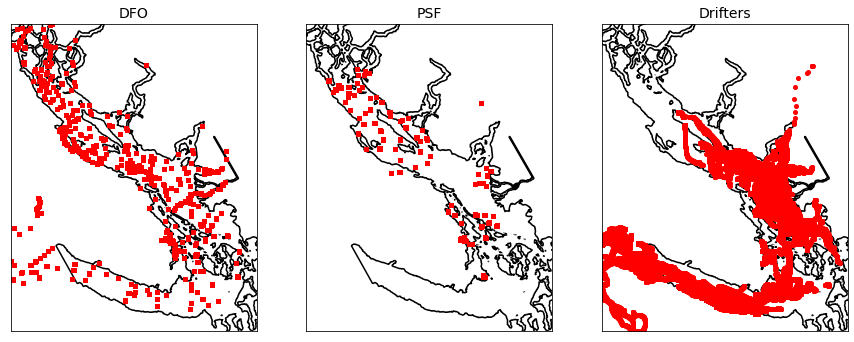

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))
xlim, ylim = [-125.5, -122.5], [48, 50.5]

axs[0].plot(DFO['base']['longitude'], DFO['base']['latitude'], 'ro', ms=4, rasterized=True)
axs[1].plot(PSF['base']['longitude'], PSF['base']['latitude'], 'ro', ms=4, rasterized=True)
axs[2].plot(drifters['base']['coords']['lon'], drifters['base']['coords']['lat'], 'ro', ms=4, rasterized=True)

for ax, title in zip(axs, ['DFO', 'PSF', 'Drifters']):
    ax.contour(longrid, latgrid, tmask, levels=[-0.01, 0.01], colors='k')
    #for region in regions:
    #    xy = [regions[region]['bounds'][0], regions[region]['bounds'][2]]
    #    width, height = [np.diff(regions[region]['bounds'][slice(*indices)])[0] for indices in [(None, 2), (2, None)]]
    #    ax.add_patch(patches.Rectangle(xy, width, height, ec=regions[region]['c'], lw=2, fill=False, zorder=10))
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_aspect(1.5)
    ax.set_title(title, fontsize=14)

fig.savefig('/scratch/bmoorema/figures/coverage.pdf', bbox_inches='tight')

***

## DFO T and S

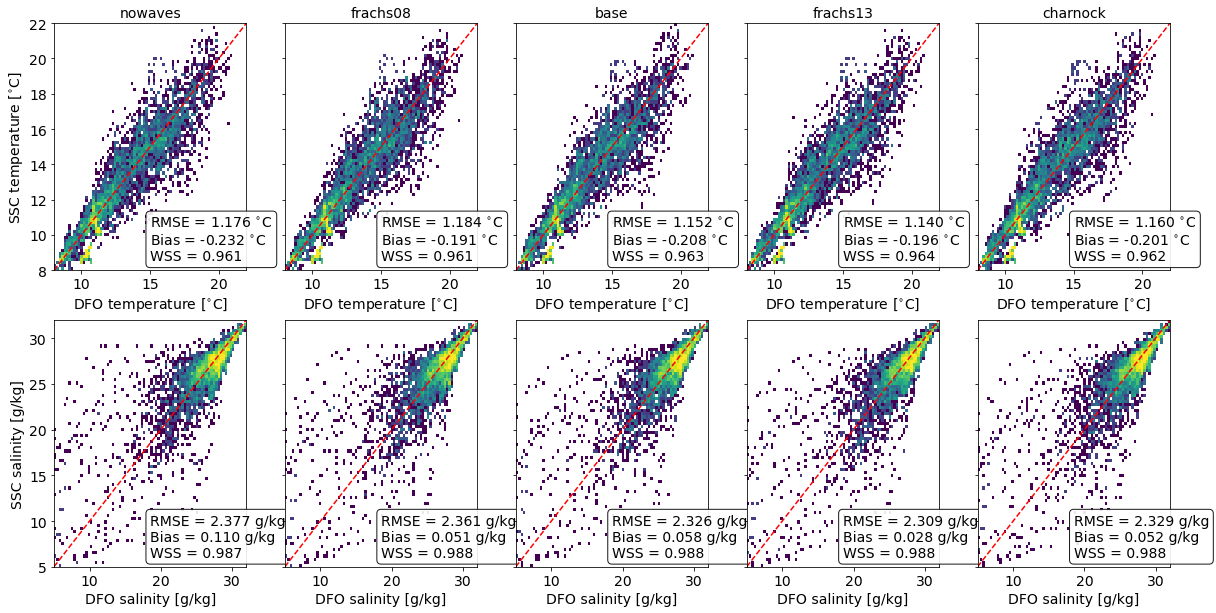

In [50]:
# All points full water column
fig, ax = plot_tracers(DFO)
fig.savefig('/scratch/bmoorema/figures/DFO_eval.pdf', bbox_inches='tight')

***

## PSF T and S

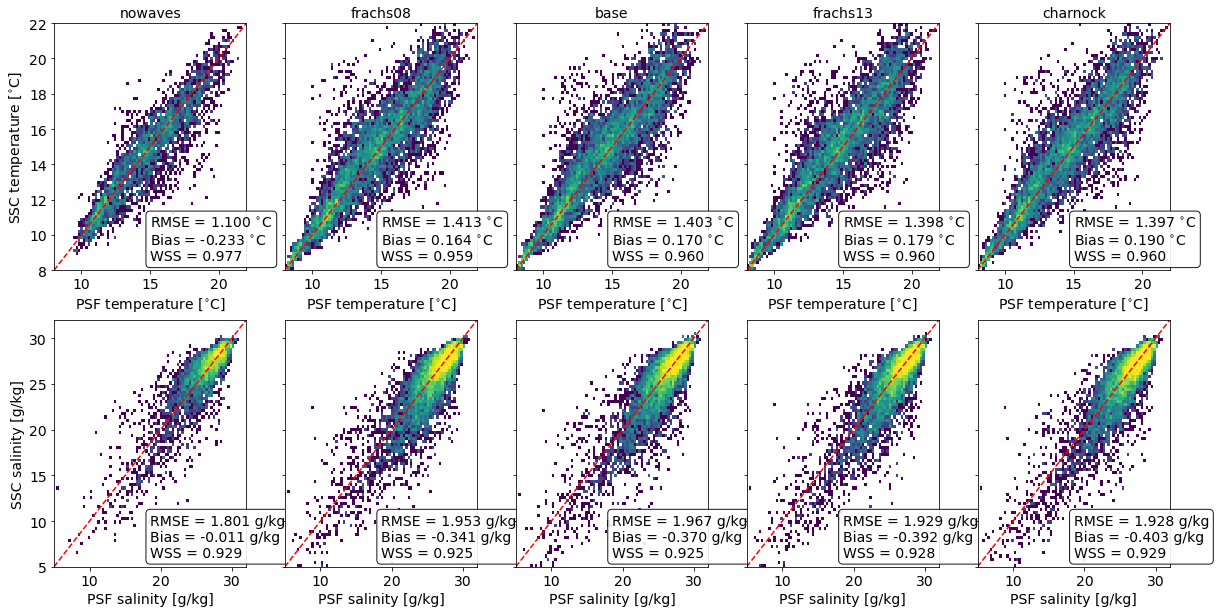

In [53]:
# All points full water column
fig, ax = plot_tracers(PSF)
fig.savefig('/scratch/bmoorema/figures/PSF_eval.pdf', bbox_inches='tight')

***

## Drifter velocities

### All drifters

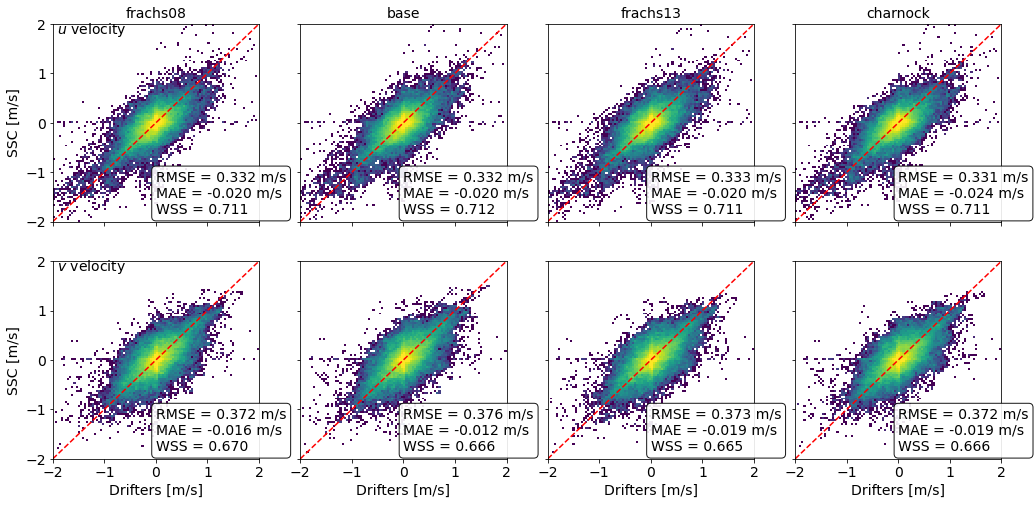

In [62]:
# Plot all drifters
fig, ax = plot_drifters(drifters)
fig.savefig('/scratch/bmoorema/figures/drifters_eval_full.pdf', bbox_inches='tight')

***

### SoG

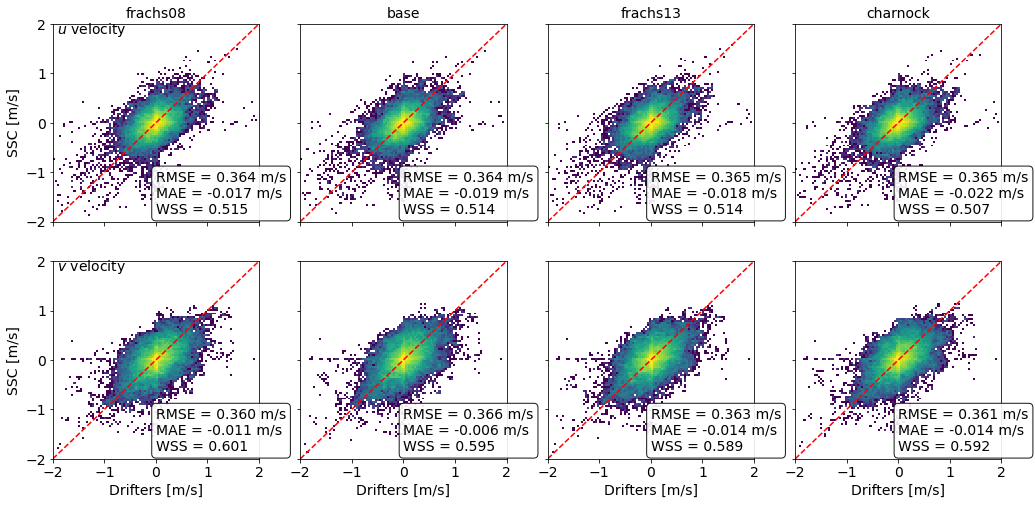

In [63]:
# SoG
fig, ax = plot_drifters(drifters, lon_bounds=regions['SoG']['bounds'][:2], lat_bounds=regions['SoG']['bounds'][2:])
fig.savefig('/scratch/bmoorema/figures/drifters_eval_SoG.pdf', bbox_inches='tight')

***

### JdF

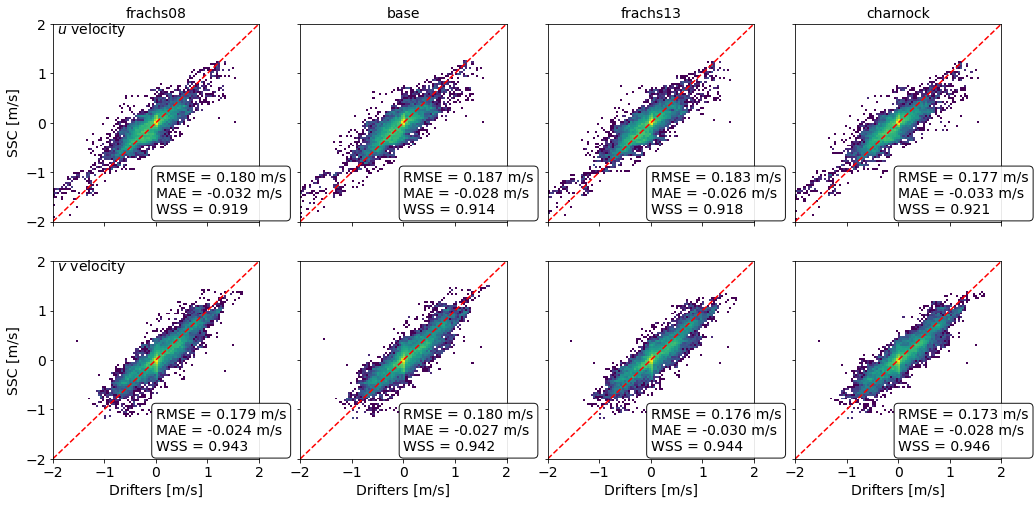

In [64]:
# JdF
fig, ax = plot_drifters(drifters, lon_bounds=regions['JdF']['bounds'][:2], lat_bounds=regions['JdF']['bounds'][2:])
fig.savefig('/scratch/bmoorema/figures/drifters_eval_JdF.pdf', bbox_inches='tight')